In [2]:
import torch
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

from pytorch_utils.data_pipeline import TSData

## Data loder for a sequential model

* For the training loader, we use a window size of 100 time steps from the range 1980-01-01 to 2000-12-31
* For the validation loader, we use the entire sequence 2001-01-01 to 2020-12-31

In [4]:
ds = xr.open_zarr('./simple_sm_model/data/era5_40N6W.zarr').load()

train_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['et', 'tp'], targets='sm', time_slice=slice('1980', '2000')),
    batch_size=50,
    shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    TSData(ds=ds, features=['et', 'tp'], targets='sm', time_slice=slice('2001', '2020'), norm_stats=train_loader.dataset.norm_stats),
    batch_size=1,
    shuffle=False)

## We can iterate the data in batches of size 50

In [5]:
for i, (x, y) in enumerate(train_loader):
    print(x.shape, y.shape)

    if i > 3:
        break


torch.Size([50, 7671, 2]) torch.Size([50, 7671, 1])
torch.Size([50, 7671, 2]) torch.Size([50, 7671, 1])
torch.Size([50, 7671, 2]) torch.Size([50, 7671, 1])
torch.Size([50, 7671, 2]) torch.Size([50, 7671, 1])
torch.Size([50, 7671, 2]) torch.Size([50, 7671, 1])


In [6]:
import torch
from torch import nn
from torch import Tensor
import numpy as np
from tqdm import tqdm
from collections import OrderedDict

In [7]:
class FCN(nn.Module):
    def __init__(
            self,
            num_feature: int,
            num_targets: int=1,
            num_hidden: int=8,
            num_layers: int=2,
            dropout: float = 0.0,
            activation: nn.Module = nn.Sigmoid,
            output_activation: nn.Module = nn.Identity,
            learning_rate: float = 0.001,
            weight_decay: float = 0.0) -> None:
        """A fully connected feed-forward model.
        
        Parameters
        -----------
        num_features: int
            The number of input features.
        num_targets: int (default is 1)
            The number of targets.
        num_hidden: int (default is 8)
            The number of hidden nodes per layer.
        num_layers: int (default is 2)
            The number of hidden nodes.
        dropout: float (default is 0.0)
            The dropout used in all hidden layers.
        activation: nn.Module (default is nn.Sigmoid)
            The activation function.
        output_activation: nn.Module (default is nn.Identity)
            The output activation function, default is nn.Identity and does not transform the output.
        learning_rate: float (default is 0.001):
            The learning rate.
        weight_decay: float (default is 0.0)
            The weight decay (L2 regularization).
        """
        super().__init__()

        layers = OrderedDict()
        in_sizes = [num_feature] + [num_hidden] * num_layers
        out_sizes = [num_hidden] * num_layers + [num_targets]

        for i, (nin, nout) in enumerate(zip(in_sizes, out_sizes)):
            is_input_layer = i == 0
            is_output_layer = i == num_layers

            layers.update({f'linear{i}': nn.Linear(in_features=nin, out_features=nout)})

            if not is_input_layer and not is_output_layer:
                layers.update({f'dropout{i}': nn.Dropout(dropout)})

            if is_output_layer:
                layers.update({f'activation{i}': output_activation()})
            else:
                layers.update({f'activation{i}': activation()})

        self.model = nn.Sequential(layers)

        self.optimizer = self.get_optimizer(self.model.parameters(), learning_rate=learning_rate, weight_decay=weight_decay)

        self.loss_fn = nn.MSELoss()

    def forward(self, x: Tensor) -> Tensor:
        return self.model(x)

    def train_epoch(self, train_loader: torch.utils.data.DataLoader) -> Tensor:
        self.train()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in train_loader:
            self.optimizer.zero_grad()

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)
            loss.backward()

            self.optimizer.step()

            loss_sum += loss.item()
            loss_counter += 1
        
        return (loss_sum / loss_counter).item()

    @torch.no_grad()
    def eval_epoch(self, valid_loader: torch.utils.data.DataLoader) -> Tensor:
        self.eval()

        loss_sum = torch.zeros(1)
        loss_counter = 0

        for x, y in valid_loader:

            y_hat = self(x)
            loss = self.loss_fn(y_hat, y)

        loss_sum += loss.item()
        loss_counter += 1

        return (loss_sum / loss_counter).item()

    def tune(self, num_epochs: int, train_loader: torch.utils.data.DataLoader, valid_loader: torch.utils.data.DataLoader) -> None:
        self.train_losses = np.zeros(num_epochs)
        self.valid_losses = np.zeros(num_epochs)

        train_loss = -1
        valid_loss = -1
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            pbar.set_description(f'train loss: {train_loss}, valid loss: {valid_loss}')

            train_loss = self.train_epoch(train_loader=train_loader)
            valid_loss = self.eval_epoch(valid_loader=valid_loader)

            self.train_losses[epoch] = train_loss
            self.valid_losses[epoch] = valid_loss

    def get_optimizer(self, params: torch.ParameterDict, learning_rate: float = 0.001, weight_decay: float = 0.0) -> torch.optim.Optimizer:
        return torch.optim.AdamW(params, lr=learning_rate, weight_decay=weight_decay)


In [8]:
model = FCN(num_feature=2, learning_rate=0.1)

In [9]:
model.tune(num_epochs=10, train_loader=train_loader, valid_loader=valid_loader)

train loss: 2.5468218326568604, valid loss: 3.3669896125793457: 100%|██████████| 10/10 [05:32<00:00, 33.28s/it]


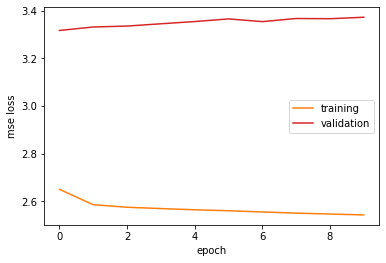

In [10]:
plt.plot(model.train_losses, label='training', color='tab:orange')
plt.plot(model.valid_losses, label='validation', color='tab:red')

plt.xlabel('epoch')
plt.ylabel('mse loss')

plt.legend()